In [1]:
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pandas as pd
import os
import numpy as np
from tqdm import trange
import librosa
from utils import *
from ipynb.fs.full.recordVowels import *

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
metadata = torchaudio.info('vowelAudio/a/aData_19_46_48.wav')
print_metadata(metadata)

 - sample_rate: 44100
 - num_channels: 2
 - num_frames: 88064
 - bits_per_sample: 16
 - encoding: PCM_S



In [57]:
d = {'fname': [], 'label': []}
for dir in os.listdir('vowelAudio'):
    for file in os.listdir('vowelAudio/'+dir):
        d['fname'].append(file)
        d['label'].append(dir)
df = pd.DataFrame.from_dict(d)
df.head()

,fname,label
0,uData_02_37_50.wav,u
1,uData_19_45_54.wav,u
2,uData_19_45_40.wav,u
3,uData_17_06_29.wav,u
4,uData_19_45_44.wav,u


In [58]:
def calc_fft(y, rate):
    print('calc')
    n = len(y)
    freq = torch.fft.rfftfreq(n, d=1/rate)
    Y = abs(torch.fft.rfft(y)/n)
    return (Y, freq)

/Users/anthony/anaconda3/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/Users/anthony/anaconda3/lib/python3.8/site-packages/torch/tensor.py:623: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/Users/anthony/anaconda3/lib/python3.8/site-packages/torch/tensor.py:623: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/Users/anthony/anaconda3/lib/python3.8/site-packages/torch/tensor.py:623: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/Users/anthony/anaconda3/lib/python3.8/site-packages/torch/tensor.py:623: ComplexWarning: Casting complex values to real discards th

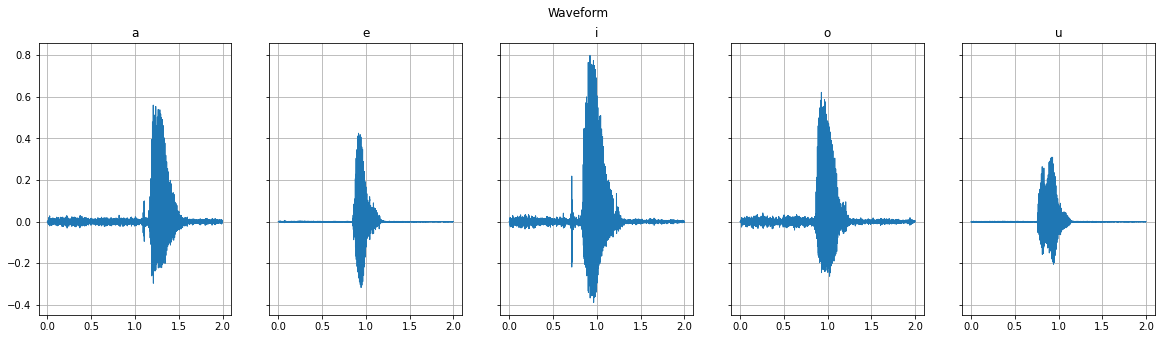

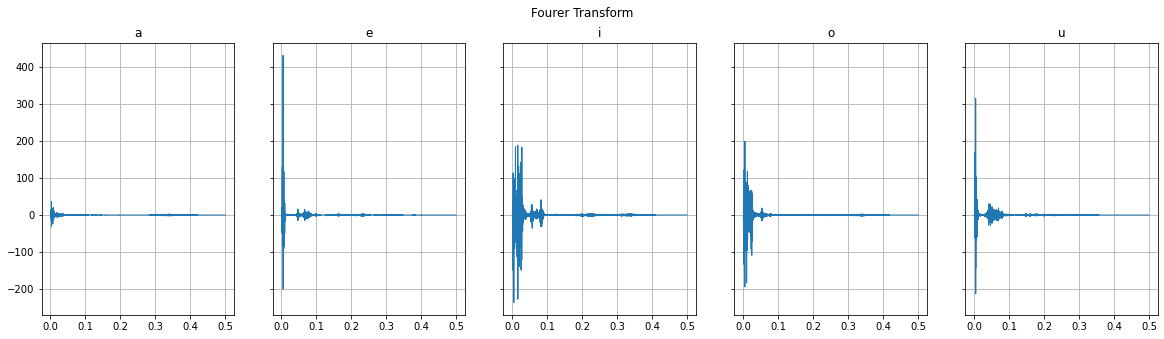

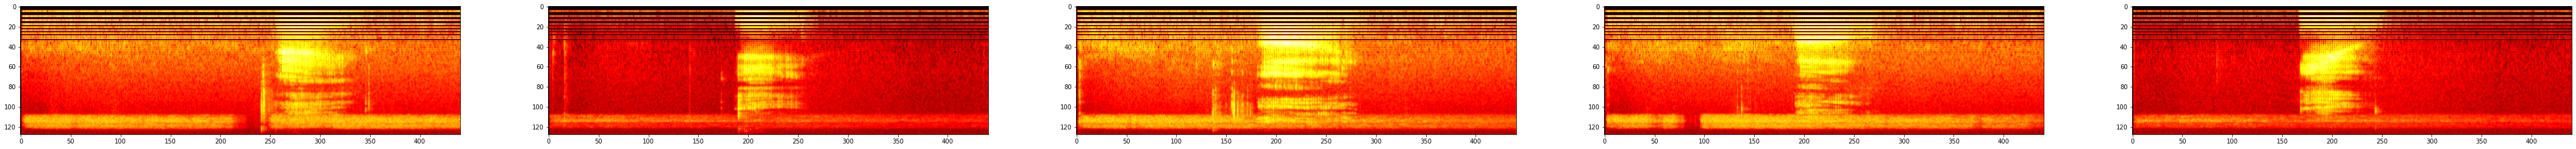

In [59]:
classes = list(np.unique(df.label))
wavforms = []
fixed_sample_rate = 44100
signals = {}
spectograms = []
ffts = []

for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    signal, rate = librosa.load('vowelAudio/'+c+'/'+wav_file, sr=44100)
    waveform, sample_rate = torchaudio.load('vowelAudio/'+c+'/'+wav_file, normalize=True)
    resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=fixed_sample_rate)
    audio_mono = torch.mean(resample_transform(waveform), dim=0, keepdim=True)
    wavforms.append([audio_mono, c])
    signals[c] = signal
    ffts.append([torch.fft.rfft(audio_mono, n=fixed_sample_rate), c])

    mel_spectogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate=fixed_sample_rate, n_mels=128)
    melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()
    
    melspectogram = mel_spectogram_transform(audio_mono)
    melspectogram_db=melspectogram_db_transform(melspectogram)
    spectograms.append([melspectogram_db, c])

plot_waveforms(wavforms, fixed_sample_rate)

plot_waveforms(ffts, fixed_sample_rate, title='Fourer Transform')

fig = plt.figure(figsize=(75, 20))
plot_spectograms(spectograms, fig)

In [60]:
ffts[0][0].shape, audio_mono.shape

(torch.Size([1, 22051]), torch.Size([1, 88064]))

In [61]:
one_hot = pd.get_dummies(df['label'])
classes = ['a', 'e', 'i', 'o', 'u']
one_hot

,a,e,i,o,u
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
103,0,1,0,0,0
104,0,1,0,0,0
105,0,1,0,0,0
106,0,1,0,0,0


In [62]:
fixed_sample_rate = 44100 #22050
class AudioDataset(Dataset):
    def __init__(self, files_dir, df):
        self.transform = transform 
        self.df = df
        self.audio_files = self.df['fname']
        self.labels = np.array(pd.get_dummies(self.df['label']))
        self.files_dir = files_dir
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = classes[torch.argmax(torch.tensor(self.labels[index]))]
        audio_file_loc = os.path.join(self.files_dir+'/'+label,self.audio_files[index])
        waveform, sr = torchaudio.load(audio_file_loc, normalize=True)
        
        resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=fixed_sample_rate)
        audio_mono = torch.mean(resample_transform(waveform), dim=0, keepdim=True).to(device)
        
        mel_spectogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate=fixed_sample_rate, n_mels=128).to(device)
        melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()
        melspectogram = mel_spectogram_transform(audio_mono)
        melspectogram_db = melspectogram_db_transform(melspectogram)
        
        fixed_length = 3 * (fixed_sample_rate//200)
        if melspectogram_db.shape[2] < fixed_length:
            melspectogram_db = torch.nn.functional.pad(
              melspectogram_db, (0, fixed_length - melspectogram_db.shape[2]))
        else:
            melspectogram_db = melspectogram_db[:, :, :fixed_length]
        
        label = torch.tensor(self.labels[index]).to(device)
            
        return melspectogram_db,label

In [65]:
dset = AudioDataset('vowelAudio', df)
len(dset)

108

In [66]:
audio, label = dset.__getitem__(40)
audio.shape, label

(torch.Size([1, 128, 660]), tensor([0, 0, 1, 0, 0], dtype=torch.uint8))

In [67]:
train_loader = DataLoader(dset,batch_size=8,shuffle=True)

Epoch [1/5], Step [1,14], Loss: 2.4116, Accuracy: 12.50%
Epoch [1/5], Step [2,14], Loss: 2.0305, Accuracy: 37.50%
Epoch [1/5], Step [3,14], Loss: 2.2109, Accuracy: 12.50%
Epoch [1/5], Step [4,14], Loss: 1.5476, Accuracy: 50.00%
Epoch [1/5], Step [5,14], Loss: 1.4258, Accuracy: 50.00%
Epoch [1/5], Step [6,14], Loss: 0.9425, Accuracy: 87.50%
Epoch [1/5], Step [7,14], Loss: 0.5945, Accuracy: 87.50%
Epoch [1/5], Step [8,14], Loss: 0.7268, Accuracy: 87.50%
Epoch [1/5], Step [9,14], Loss: 0.4157, Accuracy: 100.00%
Epoch [1/5], Step [10,14], Loss: 0.4995, Accuracy: 87.50%
Epoch [1/5], Step [11,14], Loss: 0.2892, Accuracy: 100.00%
Epoch [1/5], Step [12,14], Loss: 0.2549, Accuracy: 100.00%
Epoch [1/5], Step [13,14], Loss: 0.0746, Accuracy: 100.00%
Epoch [1/5], Step [14,14], Loss: 0.2205, Accuracy: 100.00%
Epoch [2/5], Step [1,14], Loss: 0.9051, Accuracy: 62.50%
Epoch [2/5], Step [2,14], Loss: 0.0984, Accuracy: 100.00%
Epoch [2/5], Step [3,14], Loss: 0.6943, Accuracy: 62.50%
Epoch [2/5], Step [4

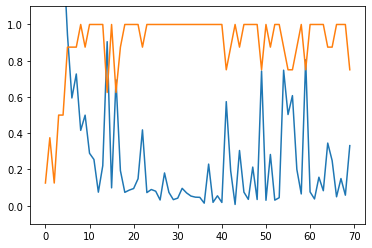

In [68]:
#training
model = models.resnet18(pretrained=True)
model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(device)

loss_list, acc_list = [],[]
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 5
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        label = torch.max(labels,1)[1]
        loss = loss_func(outputs,label)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        
        _, predicted = torch.max(outputs.data,1)
        correct = (predicted == label).sum().item()
        acc_list.append(correct/total)
        
        print('Epoch [{}/{}], Step [{},{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                       (correct/total)*100))
    
plt.ylim(-0.1,1.1)
plt.plot(loss_list)
plt.plot(acc_list)

In [86]:
model.eval()
waveform, sr = getAudio()
        
melspectogram_db = transform(waveform, sr, fixed_sample_rate)
    
with torch.no_grad():
    output = model(melspectogram_db)
print(torch.argmax(output))
print(classes[torch.argmax(output)])

* recording
* done recording


test/test_Data_17_15_16.wav
tensor(4)
u


In [87]:
torch.save(model.state_dict(), 'models/vowel_classifier.pt')